In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Более наглядный вывод для весов активов
np.set_printoptions(suppress=True, precision=4, floatmode='fixed')

В качестве 50 активов выберем активы компаний, торгующихся на Euronext Paris, с наибольшей рыночной капитализацией по причине их большей ликвидности и стабильности.

In [3]:
tickers = ['MC.PA', 'RMS.PA', 'OR.PA', 'TTE.PA', 'SU.PA', 'CDI.PA',
       'AI.PA', 'EL.PA', 'SAF.PA', 'CS.PA', 'BNP.PA', 'DG.PA', 'DSY.PA',
       'ACA.PA', 'BN.PA', 'SGO.PA', 'ENGI.PA', 'RI.PA', 'CAP.PA', 'HO.PA',
       'KER.PA', 'LR.PA', 'ML.PA', 'PUB.PA', 'VIE.PA', 'GLE.PA',
       'BOL.PA', 'AM.PA', 'AMUN.PA', 'BVI.PA', 'BIM.PA', 'EN.PA',
       'ADP.PA', 'RNO.PA', 'SW.PA', 'VIV.PA', 'CA.PA', 'AC.PA',
       'IPN.PA', 'ALO.PA', 'GET.PA', 'EDEN.PA', 'LI.PA', 'FGR.PA',
       'RXL.PA', 'GFC.PA', 'AKE.PA', 'ODET.PA', 'COV.PA', 'NEX.PA']

In [4]:
# Данные из первой части задания
all_data = pd.read_csv('~/Downloads/euronext_paris_2018.csv')

In [5]:
all_data.sample(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
65230,2018-07-23,107.550003,107.650002,106.750000,106.849998,102.313156,585024.0,SAF.PA
35782,2018-07-13,4.160000,4.160000,4.160000,4.160000,3.872000,0.0,SPEL.PA
18465,2018-05-11,25.900000,26.200001,25.799999,26.059999,20.448494,13797.0,CRI.PA


In [6]:
df_50 = all_data.query('Ticker in @tickers')

In [7]:
# Уберем из списка активы с нулевым объемом торгов за год
tickers_to_drop = df_50.groupby('Ticker').agg({'Volume': 'sum'}).query('Volume == 0').index
df_50 = df_50.query('Ticker not in @tickers_to_drop').copy()

In [8]:
# Добавим колонку с логарифмическими дневными доходностями
df_50['log_return'] = df_50.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))

In [9]:
df_50.to_csv('~/Downloads/df50.csv', index=False)

In [10]:
# Убедимся, что все строки с доходностями корректны, уберем строки с пропусками
df_returns = df_50.pivot(index='Date', columns='Ticker', values='log_return').dropna()

# Ковариационная матрица
cov_matrix = df_returns.cov()

cov_matrix.head()

Ticker,AC.PA,ACA.PA,ADP.PA,AI.PA,AKE.PA,ALO.PA,AM.PA,AMUN.PA,BIM.PA,BN.PA,...,RMS.PA,RNO.PA,RXL.PA,SAF.PA,SGO.PA,SU.PA,SW.PA,TTE.PA,VIE.PA,VIV.PA
Ticker,,,,,,,,,,,,,,,,,,,,,
AC.PA,0.000157,0.000055,0.000047,0.000052,0.000075,0.000037,0.000051,0.000070,0.000052,0.000050,...,0.000051,0.000062,0.000089,0.000069,0.000068,0.000081,0.000059,0.000050,0.000056,0.000056
ACA.PA,0.000055,0.000162,0.000039,0.000059,0.000091,0.000043,0.000051,0.000122,0.000060,0.000034,...,0.000019,0.000081,0.000074,0.000066,0.000085,0.000089,0.000047,0.000072,0.000041,0.000068
ADP.PA,0.000047,0.000039,0.000159,0.000042,0.000051,0.000021,0.000047,0.000063,0.000066,0.000042,...,0.000045,0.000066,0.000060,0.000058,0.000046,0.000048,0.000040,0.000038,0.000045,0.000050
AI.PA,0.000052,0.000059,0.000042,0.000118,0.000090,0.000044,0.000065,0.000081,0.000048,0.000059,...,0.000052,0.000069,0.000084,0.000090,0.000075,0.000092,0.000061,0.000071,0.000057,0.000061
AKE.PA,0.000075,0.000091,0.000051,0.000090,0.000221,0.000063,0.000088,0.000113,0.000084,0.000055,...,0.000073,0.000109,0.000113,0.000112,0.000102,0.000125,0.000055,0.000070,0.000048,0.000085


In [11]:
log_return_mean = df_returns.mean()
log_return_std = df_returns.std()
n_assets = len(cov_matrix.columns)

ms = pd.DataFrame({
    'log_return_mean': log_return_mean,
    'log_return_std': log_return_std
}).reset_index().rename(columns={'index': 'Ticker'})

In [12]:
ms.head(3)

,Ticker,log_return_mean,log_return_std
0,AC.PA,-0.000698,0.012522
1,ACA.PA,-0.001414,0.012708
2,ADP.PA,0.000125,0.012591


#### Функция для поиска весов активов

In [13]:
# Функция для вычисления дисперсии портфеля
def portfolio_variance(weights, cov_matrix):
    return weights @ cov_matrix @ weights.T * 254

In [14]:
# Функция для задачи Risk Aversion
def objective_function(weights, cov_matrix, mean_returns, gamma):
    return gamma * np.sqrt(portfolio_variance(weights, cov_matrix) / 254) - np.dot(weights, mean_returns)

In [15]:
def optimize_portfolio(cov_matrix, mean_returns=None, target_return=None, allow_short_sales=True, gamma=None, print_weights=False):

    n_assets = len(cov_matrix.columns)
    init_guess = np.ones(n_assets) / n_assets
    bounds = None if allow_short_sales else [(0, 1) for _ in range(n_assets)]
    
    constraints = [{'type': 'eq', 'fun': lambda W: np.sum(W) - 1}]
    if target_return is not None:
        constraints.append({'type': 'eq', 'fun': lambda W: np.dot(mean_returns, W) - target_return})
        
    if gamma is None:
        result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        result = minimize(objective_function, init_guess, args=(cov_matrix, mean_returns, gamma), method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        if(print_weights):
            if(target_return is None):
                print(f'\033[1mВеса искомого портфеля из {n_assets} активов с короткими продажам:\033[0m\n {result.x}') if allow_short_sales \
                else print(f'\033[1mВеса искомого портфеля из {n_assets} активов без коротких продаж:\033[0m\n {result.x}')
            else:
                print(f'Веса портфеля из {n_assets} активов с короткими продажами для уровня доходности {target_return}:\n {result.x}') if allow_short_sales \
                else print(f'Веса портфеля из {n_assets} без коротких продаж для уровня доходности {target_return}:\n {result.x}')
        
        return result.x
    else:
        print(f"Оптимизация не удалась для целевой доходности {target_return}")
        return None

In [16]:
# Найдем веса для задач с разрешением и запретом коротких продаж
weights_short = optimize_portfolio(cov_matrix, allow_short_sales=True)
weights_no_short = optimize_portfolio(cov_matrix, allow_short_sales=False)

print("Веса портфеля с короткими продажами:", weights_short)
print("Веса портфеля без коротких продаж:", weights_no_short)

Веса портфеля с короткими продажами: [ 0.0357 -0.0342  0.0410  0.0752 -0.0086  0.1240  0.0127 -0.0390 -0.0128
  0.0093 -0.0715  0.0436  0.0397  0.0132 -0.0642  0.1621  0.1526  0.1277
 -0.1013 -0.0108 -0.0269  0.0693 -0.0396 -0.0355  0.0602  0.1381  0.0643
  0.1768  0.0695 -0.0023 -0.0485 -0.0360  0.0919 -0.2359  0.0518  0.0001
 -0.0359 -0.0058  0.0289  0.0949  0.1275 -0.0277 -0.0605 -0.0505  0.0337
 -0.0278  0.0134  0.1100 -0.0150  0.0230]
Веса портфеля без коротких продаж: [0.0024 0.0000 0.0372 0.0000 0.0000 0.0987 0.0000 0.0000 0.0000 0.0206
 0.0000 0.0000 0.0000 0.0249 0.0000 0.0000 0.1539 0.0923 0.0000 0.0000
 0.0000 0.0598 0.0000 0.0000 0.0000 0.1698 0.0519 0.0550 0.0332 0.0000
 0.0000 0.0000 0.0081 0.0000 0.0000 0.0000 0.0000 0.0000 0.0364 0.0517
 0.0198 0.0000 0.0000 0.0000 0.0000 0.0000 0.0274 0.0569 0.0000 0.0000]


Портфель с короткими продажами не содержит нулевых весов, все активы участвуют в создании портфеля. Портфель без коротких продаж, напротив, содержит большое количество нулевых весов.

#### Функция для отрисовки портфеля на карте активов

In [17]:
def plot_portfolio(ms, weights, portfolio_names=['Портфель'], colors=['green'], markers=['o']):
    
    plt.figure(figsize=(18, 10), dpi=150)

    # Карта активов и подписи к ним
    plt.scatter(ms['log_return_std'], ms['log_return_mean'], color='darkblue', label='Все активы')
    for i, row in ms.iterrows():
        plt.text(row['log_return_std'], row['log_return_mean'], row['Ticker'], color='black', fontsize=9, ha='right')

    # Добавление портфеля на карту активов
    if weights is not None:
        for i in range(len(weights)):
            portfolio_risk = np.sqrt(portfolio_variance(weights[i], cov_matrix)) / np.sqrt(254)
            portfolio_return = np.dot(weights[i], ms['log_return_mean'])
            plt.scatter([portfolio_risk], [portfolio_return], color=colors[i], marker=markers[i], s=100, label=portfolio_names[i])

    plt.xlabel(r'$\hat{\sigma}$', fontsize=30)
    plt.ylabel(r'$\hat{\mathbb{E}}$', fontsize=30)
    plt.title('Карта активов и портфели', fontsize=30)
    plt.legend()
    plt.grid()
    plt.show()

### Портфели из 50 активов

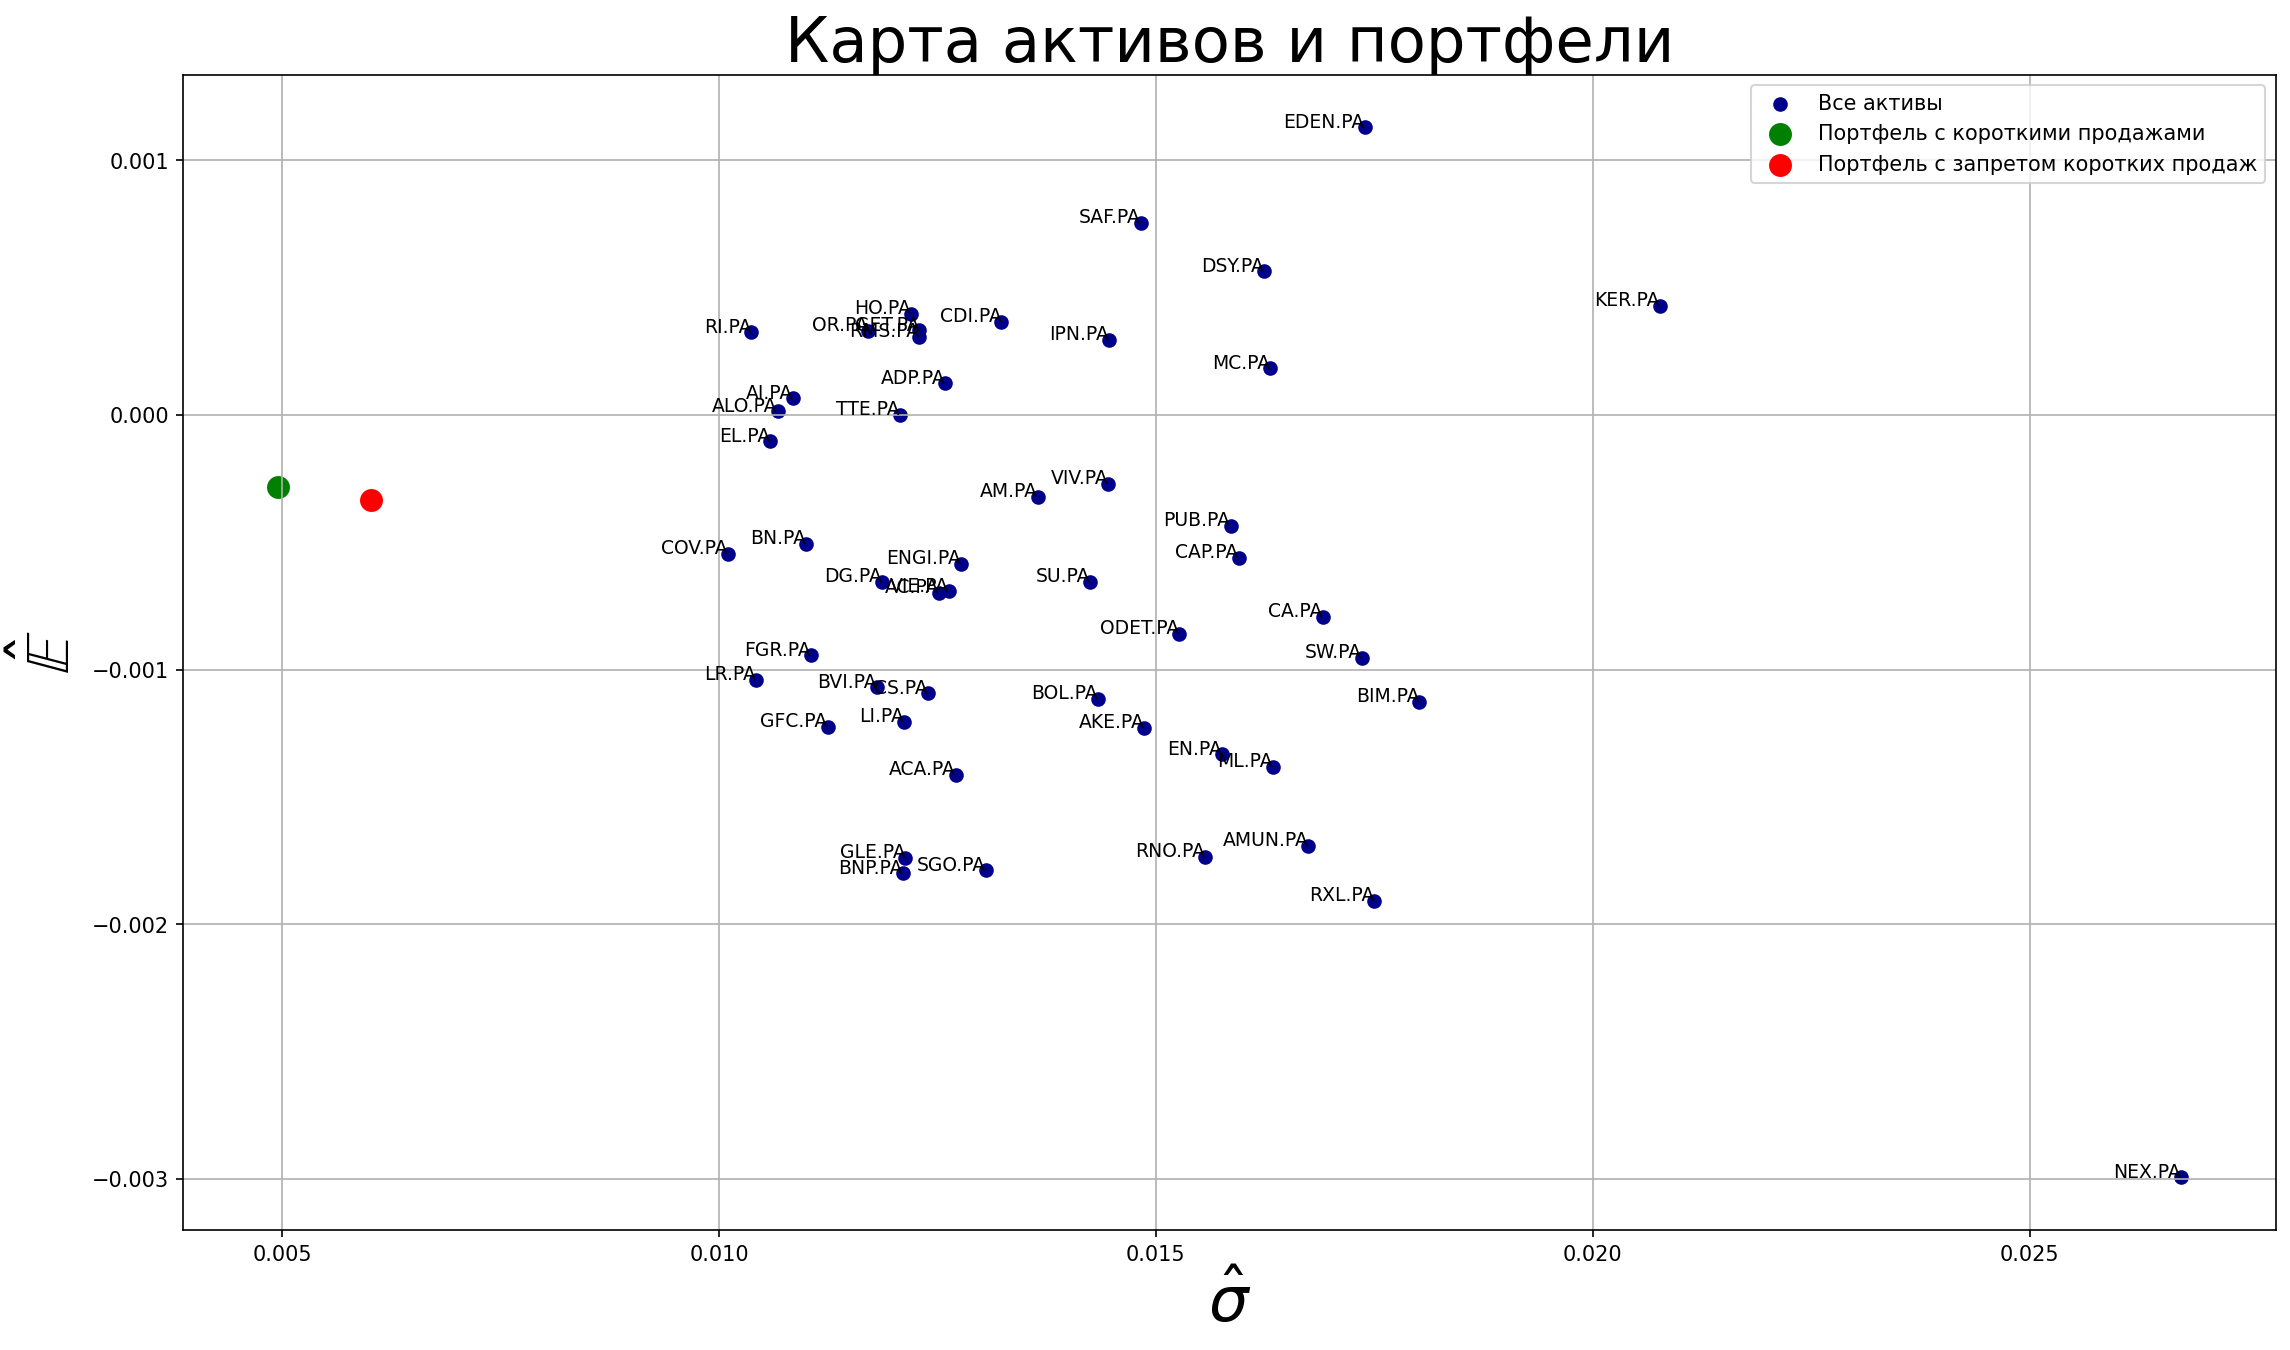

In [18]:
# Построим портфели для 50 активов
plot_portfolio(ms, weights=[weights_short, weights_no_short],
               portfolio_names=['Портфель с короткими продажами', 'Портфель с запретом коротких продаж'],
               colors=['green','red'],
              markers=['o', 'o'])

#### Функция для построения эффективного фронта

In [19]:
def plot_efficient_frontier(ms, cov_matrices, mean_returns_list, portfolio_names, colors, frontier_colors, markers, flg=False, num_points=100, gamma=None, print_weights=False):
    
    # Построение карты активов, для портфеля из 10 активов выбранные активы отображаются другим цветом
    plt.figure(figsize=(18, 10), dpi=150)
    
    index_top_10 = None
    for i, returns in enumerate(mean_returns_list):
        if len(returns) == 10:
            index_top_10 = i
            break
     
    if index_top_10 is not None:
        top_10_tickers = ms.query('Ticker in @mean_returns_list[@index_top_10].index')['Ticker'].values
    else:
        top_10_tickers = []
        
    top_10_assets = ms[ms['Ticker'].isin(top_10_tickers)]
    other_assets = ms[~ms['Ticker'].isin(top_10_tickers)]
    if index_top_10 is not None:
        plt.scatter(top_10_assets['log_return_std'], top_10_assets['log_return_mean'], color='purple', label='Выбранные 10 активов')
    plt.scatter(other_assets['log_return_std'], other_assets['log_return_mean'], color='darkblue', label='Все активы')
    for i, row in ms.iterrows():
        plt.text(row['log_return_std'], row['log_return_mean'], row['Ticker'], color='black', fontsize=9, ha='right')

    
    # Для каждого набора активов строим эффективный фронт
    for j in range(len(cov_matrices)):
        cov_matrix = cov_matrices[j]
        mean_returns = mean_returns_list[j]
        portfolio_name = portfolio_names[j]
        n_assets = len(mean_returns)
        
        for i, allow_short_sales in enumerate([True, False]):
            # Сначала находим портфель с минимальным риском для определения начала эффективного фронта
            weights_min_risk = optimize_portfolio(cov_matrix, allow_short_sales=allow_short_sales, gamma=None, print_weights=print_weights)
            portfolio_risk_min = np.sqrt(portfolio_variance(weights_min_risk, cov_matrix)) / np.sqrt(254)
            portfolio_return_min = np.dot(weights_min_risk, mean_returns)
            
            # Определяем целевые уровни доходности, начиная с минимального риска
            target_returns = np.linspace(portfolio_return_min, mean_returns.max(), num_points)
            
            frontier_risks = []
            frontier_returns = []

            # Оптимизация портфелей для каждого целевого уровня доходности     
            for target in target_returns:
                weights = optimize_portfolio(cov_matrix, mean_returns, target_return=target, allow_short_sales=allow_short_sales, print_weights=print_weights)
                if weights is not None:
                    portfolio_risk = np.sqrt(portfolio_variance(weights, cov_matrix)) / np.sqrt(254)
                    portfolio_return = np.dot(weights, mean_returns)
                    frontier_risks.append(portfolio_risk)
                    frontier_returns.append(portfolio_return)

            # Отображение эффективного фронта
            label = f'Эффективный фронт для {n_assets} активов ({"короткие продажи" if allow_short_sales else "без коротких продаж"})'
            plt.plot(frontier_risks, frontier_returns, frontier_colors[2*j+i], label=label)


            # Если ищем оптимальный индивидуальный портфель, пересчитаем веса, оптимизируя функцию полезности
            if gamma is not None:
                weights_min_risk = optimize_portfolio(cov_matrix, mean_returns, allow_short_sales=allow_short_sales, gamma=gamma, print_weights=print_weights)
            portfolio_risk_min = np.sqrt(portfolio_variance(weights_min_risk, cov_matrix)) / np.sqrt(254)
            portfolio_return_min = np.dot(weights_min_risk, mean_returns)
            
            plt.scatter([portfolio_risk_min], [portfolio_return_min], color=colors[2*j+i], marker=markers[2*j+i], s=100, label=f'{portfolio_name}')
              

            
    for i, row in ms.iterrows():
        plt.text(row['log_return_std'], row['log_return_mean'], row['Ticker'], color='black', fontsize=9, ha='right')
        
    # Отображение на графике портфеля с равными долями активов, если требуется    
    if flg:
        for i in range(len(mean_returns_list)):
            equal_weights = np.ones(len(mean_returns_list[i])) / len(mean_returns_list[i])
            plt.scatter([np.sqrt(portfolio_variance(equal_weights, cov_matrices[i])) / np.sqrt(254)],
                [np.dot(equal_weights, mean_returns_list[i])],
                color='blue', marker='x', s=100, label=f'Портфель с равными долями ({len(mean_returns_list[i])} активов)')
            
    plt.xlabel(r'$\hat{\sigma}$', fontsize=30)
    plt.ylabel(r'$\hat{\mathbb{E}}$', fontsize=30)
    plt.title('Эффективные фронты', fontsize=30)
    plt.legend()
    plt.grid()
    plt.show()

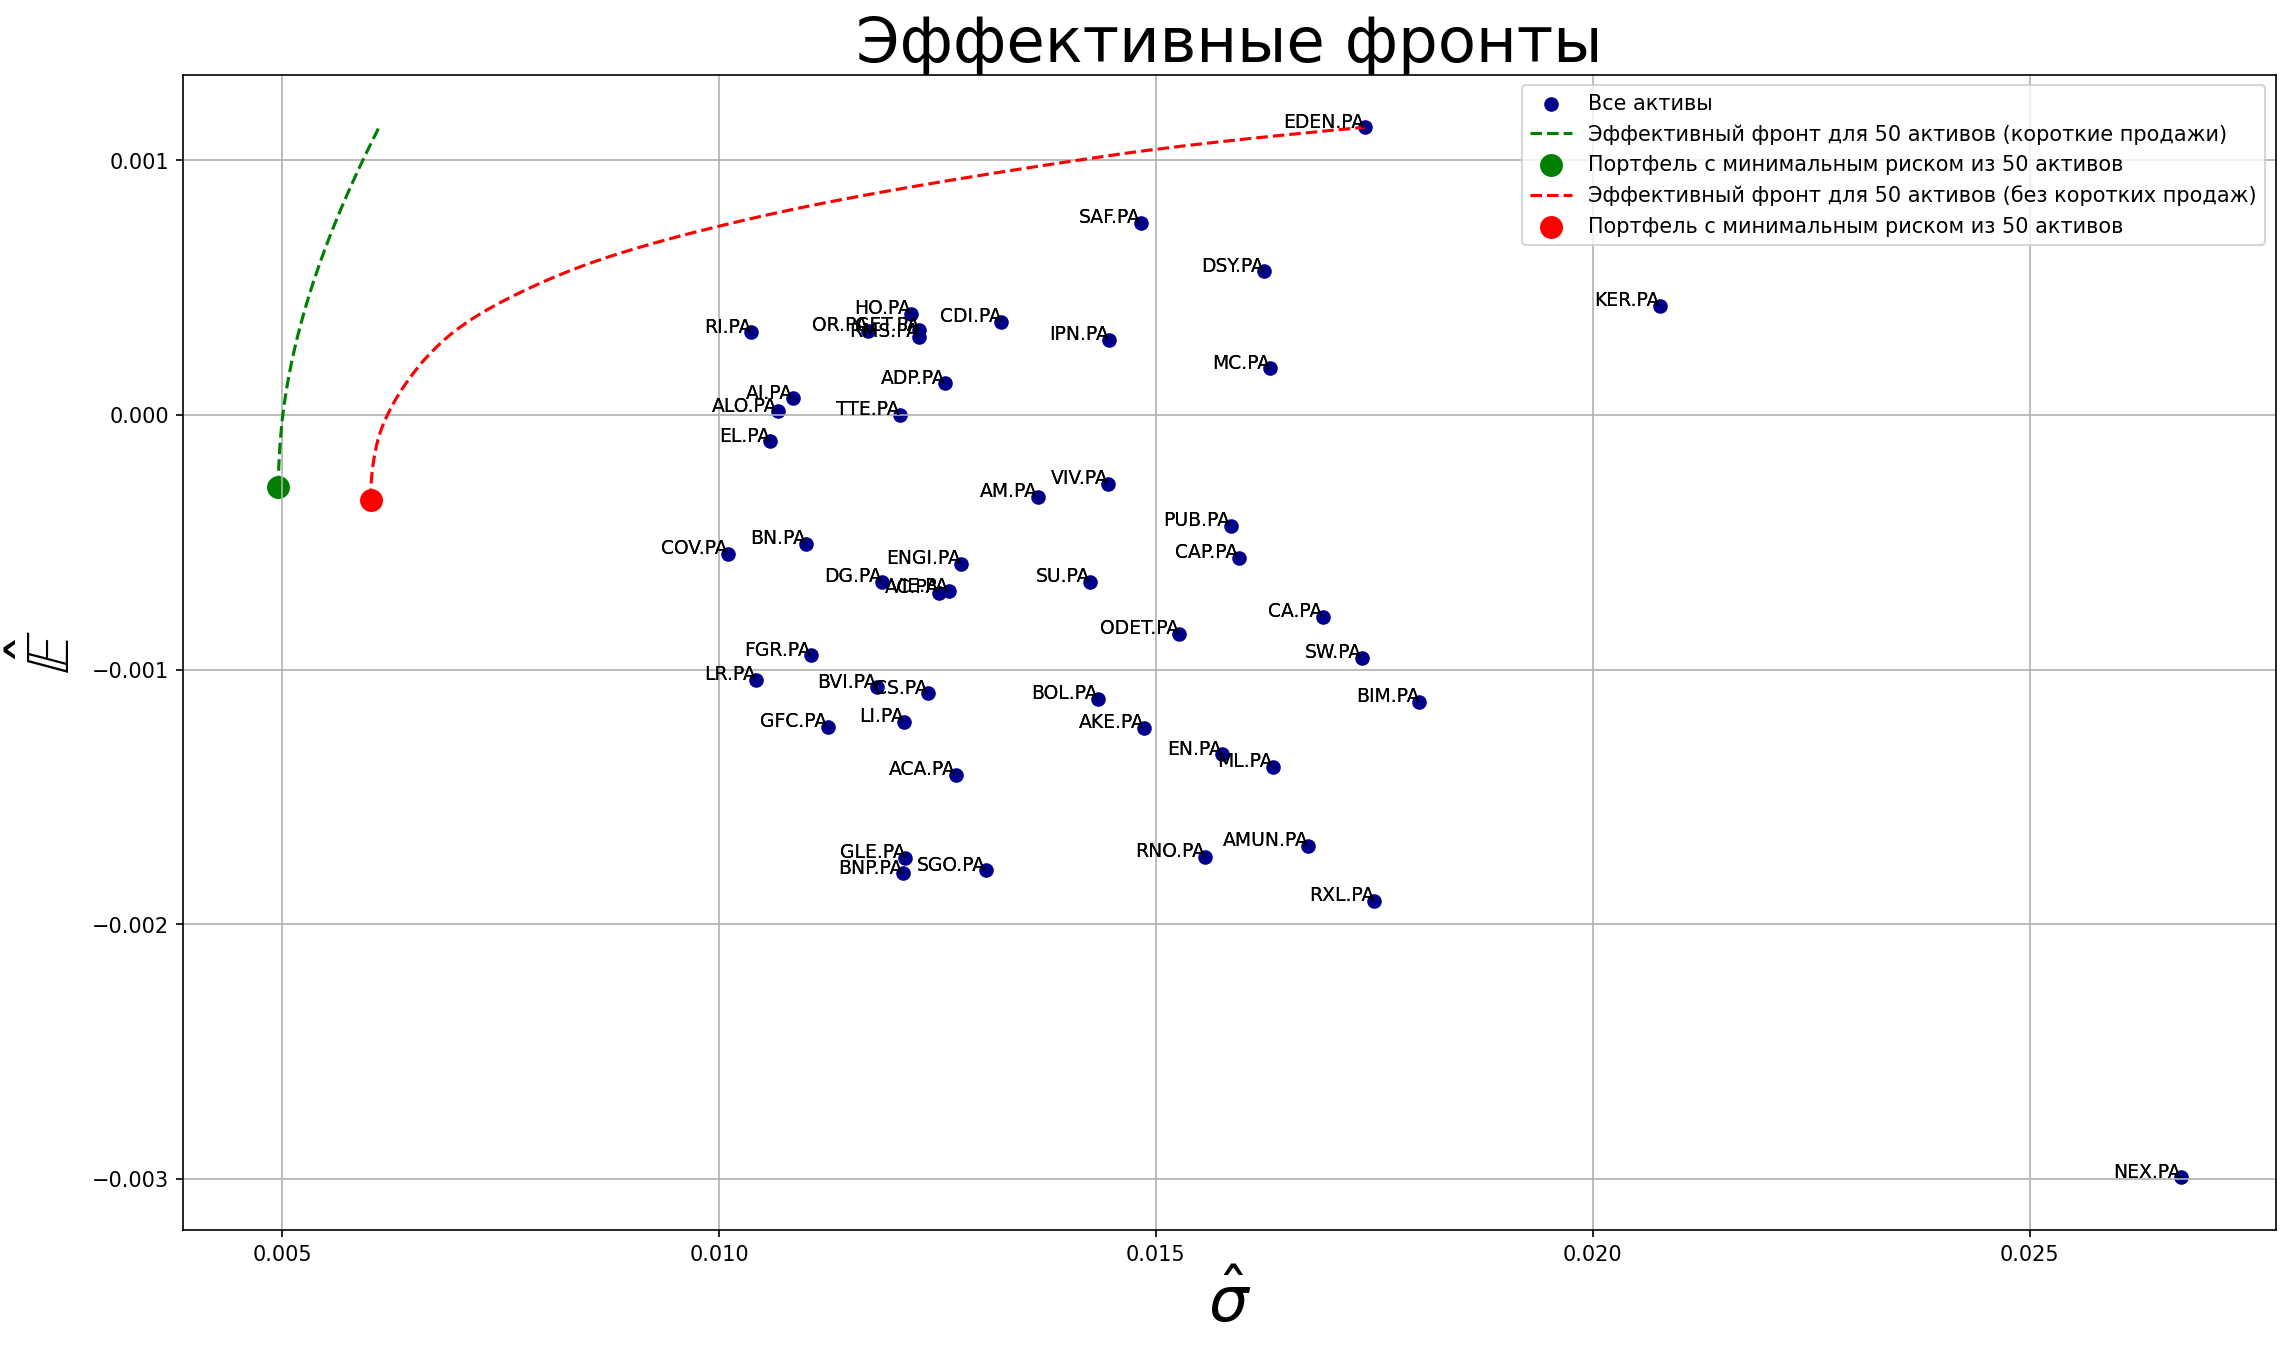

In [20]:
# Определим параметры для эффективных фронтов и портфелей
cov_matrices = [cov_matrix]
mean_returns_list = [log_return_mean]
portfolio_names = ['Портфель с минимальным риском из 50 активов']
colors = ['green', 'red']
frontier_colors = ['g--', 'r--']
markers = ['o', 'o']
print_weights = False

# Построение эффективного фронта и портфеля с минимальным риском
plot_efficient_frontier(ms, cov_matrices, mean_returns_list, portfolio_names, colors, frontier_colors, markers, print_weights=print_weights)

Эффективный фронт с короткими продажами обеспечивает более высокий уровень доходности для того же уровня риска. Возможность использовать короткие позиции позволяет строить более гибкие стратегии, которые улучшают характеристики портфеля. 

### Портфель с равными долями

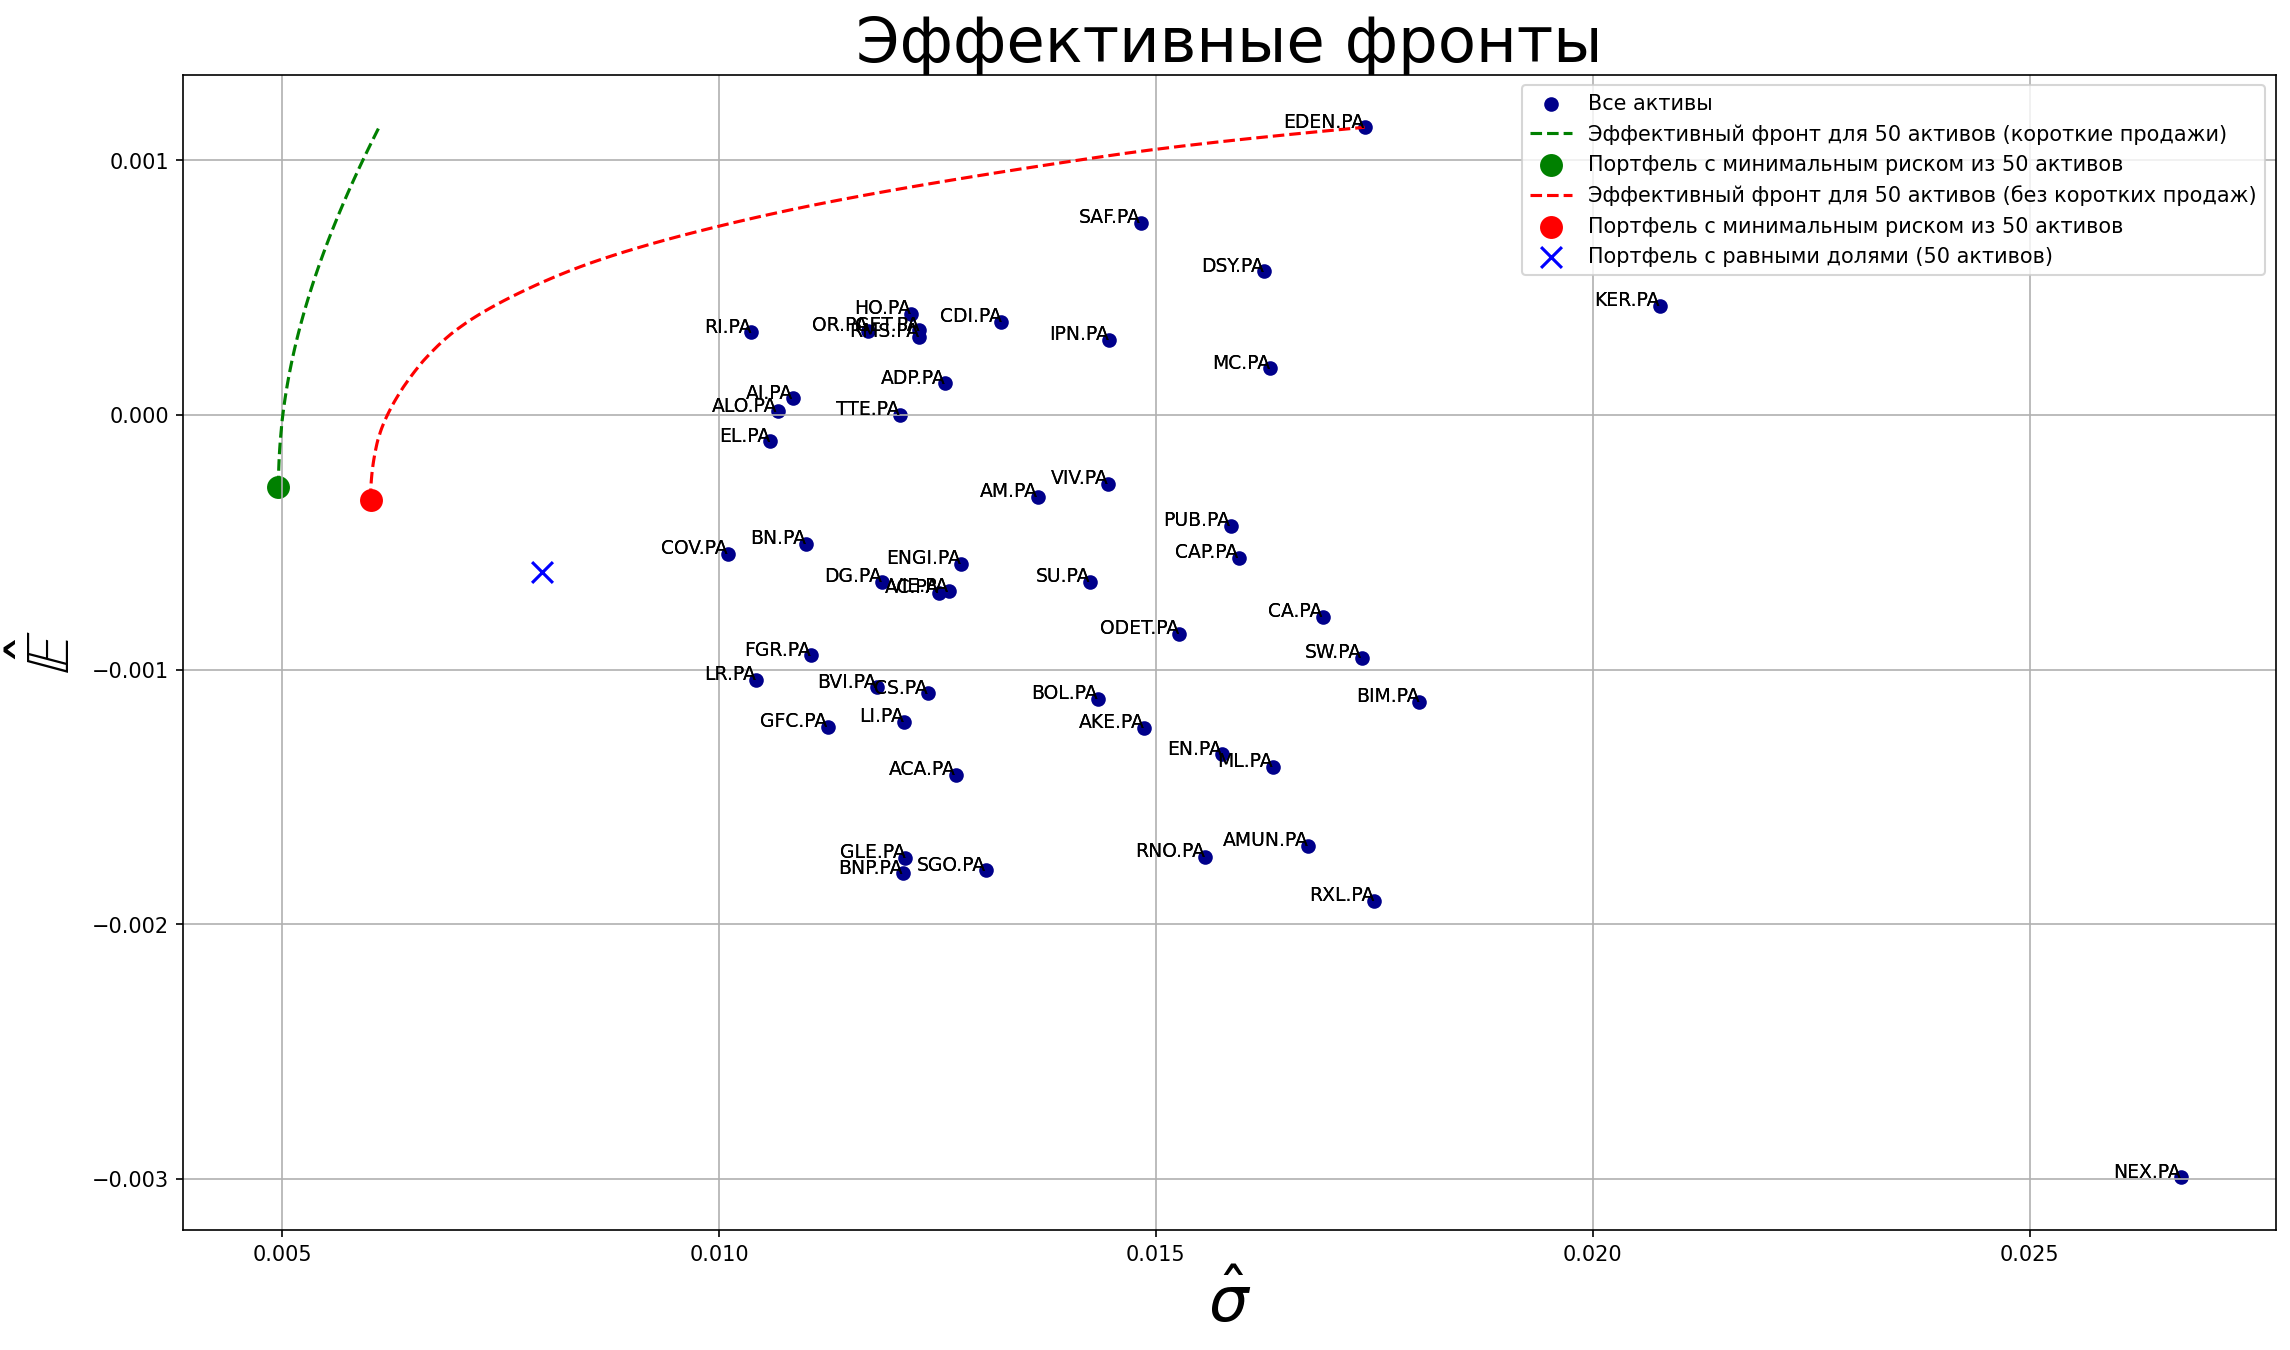

In [21]:
# Определим параметры для эффективных фронтов и портфелей
cov_matrices = [cov_matrix]
mean_returns_list = [log_return_mean]
portfolio_names = ['Портфель с минимальным риском из 50 активов']
colors = ['green', 'red']
frontier_colors = ['g--', 'r--']
markers = ['o', 'o']
print_weights = False

# Построение эффективного фронта и портфелей с минимальным риском и равными долями активов
plot_efficient_frontier(ms, cov_matrices, mean_returns_list, portfolio_names, colors, frontier_colors, markers, flg=True, print_weights=print_weights)

 Портфель с равными долями расположен далеко от обоих эффективных фронтов, что указывает на его неэффективность с точки зрения доходности и риска.

### Портфель для 10 активов с наибольшими значениями $\large \frac{\hat{\mathbb{E}}}{\hat{\sigma}}$

In [22]:
sharpe_ratios = log_return_mean / log_return_std

# Отберем 10 активов с наивысшим Sharpe Ratio
top_10_tickers = sharpe_ratios.nlargest(10).index

# Отберем данные для этих 10 активов
df_returns_top_10 = df_returns[top_10_tickers]
cov_matrix_top_10 = df_returns_top_10.cov()

# Средние доходности для этих 10 активов
log_return_mean_top_10 = log_return_mean[top_10_tickers]

# Тикеры 10 активов
top_10_tickers

Index(['EDEN.PA', 'SAF.PA', 'DSY.PA', 'HO.PA', 'RI.PA', 'OR.PA', 'CDI.PA',
       'GET.PA', 'RMS.PA', 'KER.PA'],
      dtype='object', name='Ticker')

Веса искомого портфеля из 50 активов с короткими продажам:
 [ 0.0357 -0.0342  0.0410  0.0752 -0.0086  0.1240  0.0127 -0.0390 -0.0128
  0.0093 -0.0715  0.0436  0.0397  0.0132 -0.0642  0.1621  0.1526  0.1277
 -0.1013 -0.0108 -0.0269  0.0693 -0.0396 -0.0355  0.0602  0.1381  0.0643
  0.1768  0.0695 -0.0023 -0.0485 -0.0360  0.0919 -0.2359  0.0518  0.0001
 -0.0359 -0.0058  0.0289  0.0949  0.1275 -0.0277 -0.0605 -0.0505  0.0337
 -0.0278  0.0134  0.1100 -0.0150  0.0230]
Веса портфеля из 50 активов с короткими продажами для уровня доходности -0.000283562519543335:
 [ 0.0357 -0.0344  0.0410  0.0751 -0.0087  0.1245  0.0125 -0.0387 -0.0134
  0.0095 -0.0713  0.0437  0.0397  0.0133 -0.0640  0.1619  0.1525  0.1282
 -0.1020 -0.0111 -0.0265  0.0693 -0.0404 -0.0353  0.0604  0.1378  0.0647
  0.1772  0.0696 -0.0018 -0.0485 -0.0362  0.0919 -0.2359  0.0514  0.0003
 -0.0350 -0.0059  0.0288  0.0951  0.1276 -0.0279 -0.0601 -0.0505  0.0335
 -0.0283  0.0132  0.1097 -0.0150  0.0227]
Веса портфеля из 50 активов с 

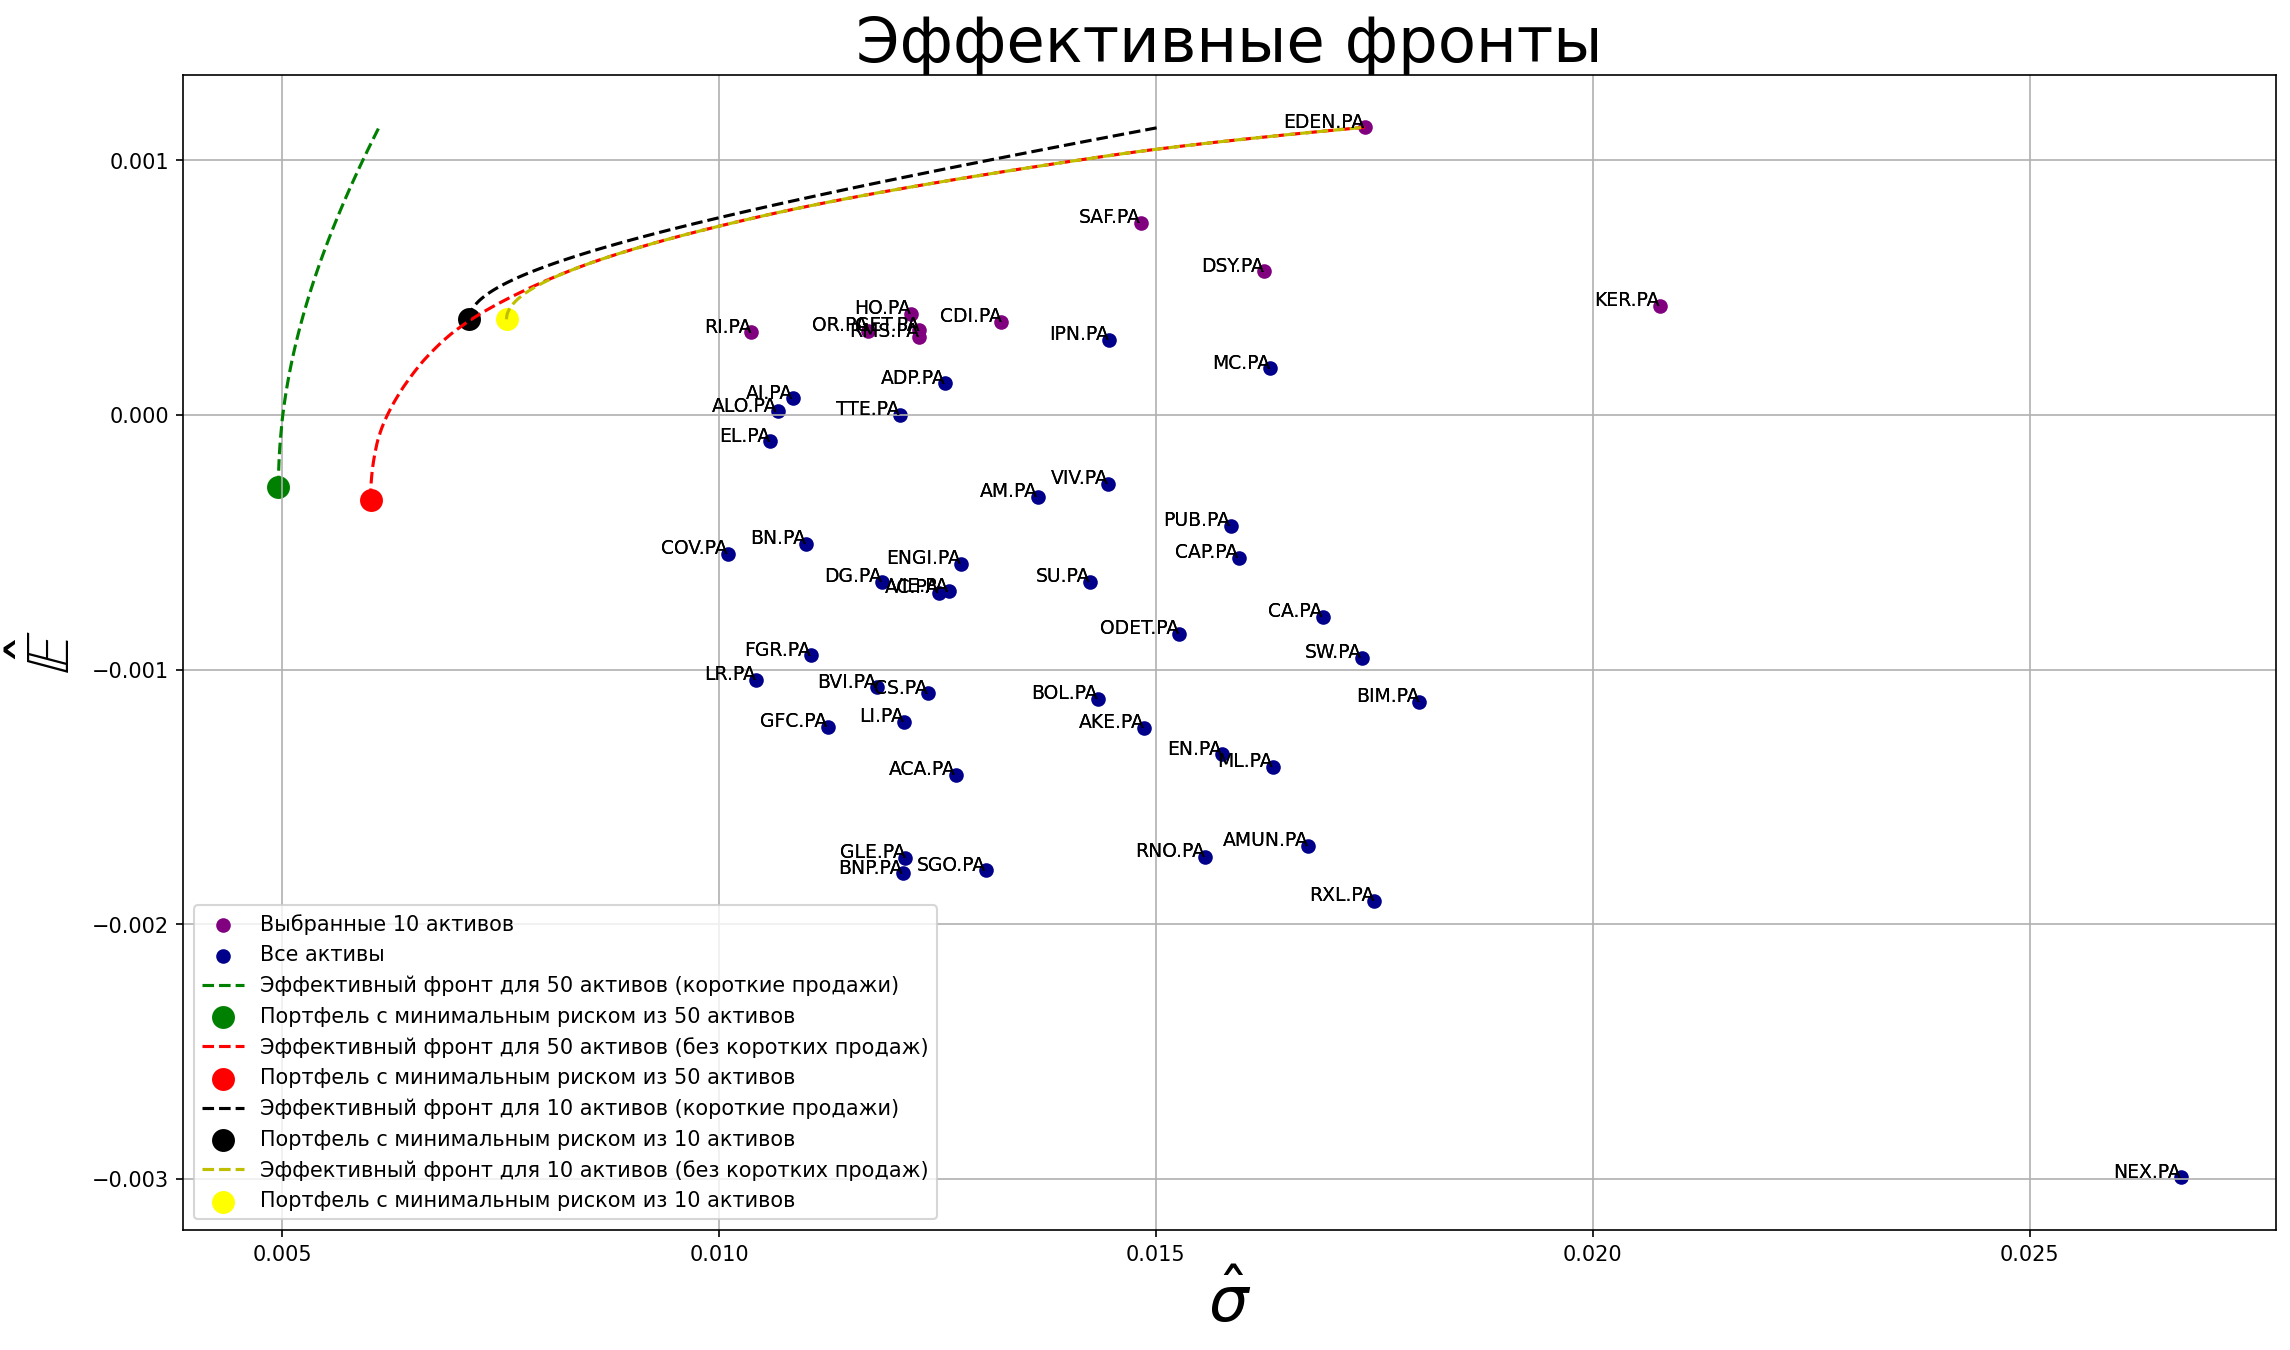

In [23]:
# Определим параметры для эффективных фронтов и портфелей
cov_matrices = [cov_matrix, cov_matrix_top_10]
mean_returns_list = [log_return_mean, log_return_mean_top_10]
portfolio_names = ['Портфель с минимальным риском из 50 активов', 'Портфель с минимальным риском из 10 активов']
colors = ['green', 'red', 'black', 'yellow']
frontier_colors = ['g--', 'r--', 'k--', 'y--']
markers = ['o', 'o', 'o', 'o']
print_weights = True

# Построение эффективного фронта. Также сначала выводятся веса для портфелей из 50 и 10 активов для каждого заданного уровня доходности,
# чтобы убедиться, что задача оптимизации для 10 активов решается корректно и портфели с короткими продажами содержат отрицательные веса
plot_efficient_frontier(ms, cov_matrices, mean_returns_list, portfolio_names, colors, frontier_colors, markers, print_weights=print_weights)

Эффективные фронты для 10 и 50 активов для портфелей с короткими продажами достаточно далеки друг от друга. Возможно, это можно объяснить тем, что в портфеле из 10 активов присутствуют только активы с "хорошими" значениями отношения доходности к риску, поэтому много заработать на коротких продажах мы не можем.

Эффективные фронты для 10 и 50 активов для портфелей без коротких продаж практически совпадают друг с другом, когда значения $\hat{\mathbb{E}}$ достижимы. Вероятно, это объясняется тем, что в портфель из 10 активов были отобраны активы с наилучшими характеристиками по соотношению доходности и риска, и добавление оставшихся активов из портфеля из 50 активов не приносит значительных улучшений в условиях запрета на короткие продажи. 

### Risk Aversion

В качестве отношения к риску выберем ${{\gamma}}$ = 0.7, ожидая, что это соответствует умеренной степени неприятия риска.

In [24]:
gamma = 0.7

In [25]:
weights_ind_short = optimize_portfolio(cov_matrix, log_return_mean, allow_short_sales=True, gamma=gamma)
weights_ind_no_short = optimize_portfolio(cov_matrix, log_return_mean, allow_short_sales=False, gamma=gamma)
print("Веса личного портфеля с короткими продажами:", weights_ind_short)
print("Веса личного портфеля без коротких продаж:", weights_ind_no_short)

Веса личного портфеля с короткими продажами: [ 0.0795  0.0460  0.1072  0.1166 -0.0669  0.1654 -0.0040 -0.0930 -0.0476
 -0.0368 -0.1102  0.0678 -0.0915 -0.0071 -0.0842  0.1350  0.2020  0.1450
 -0.0333  0.0210  0.0601  0.0663 -0.0420 -0.0668 -0.0259  0.2180 -0.0365
  0.0847  0.0860  0.0146 -0.0497 -0.0598  0.0176 -0.1873  0.0726 -0.0327
 -0.1028  0.0335  0.0208  0.1537  0.1325 -0.0668 -0.1318  0.0674 -0.0110
  0.0313  0.0081  0.1847 -0.0215  0.0714]
Веса личного портфеля без коротких продаж: [0.0000 0.0000 0.0669 0.0029 0.0000 0.1089 0.0000 0.0000 0.0000 0.0109
 0.0000 0.0000 0.0000 0.0190 0.0000 0.0000 0.0997 0.0515 0.0000 0.0000
 0.0019 0.0711 0.0000 0.0000 0.0000 0.2280 0.0000 0.0000 0.0760 0.0121
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0134 0.0279 0.0875
 0.0491 0.0000 0.0000 0.0000 0.0000 0.0000 0.0004 0.0725 0.0000 0.0003]


Для обоих портфелей наибольшие положительные веса имеют компании со следующими тикерами:  
CDI.PA (вес в портфеле с короткими продажами 0.1654, без коротких продаж - 0.1089)   
ENGI.PA (вес в портфеле с короткими продажами 0.2020, без коротких продаж - 0.0997)  
GLE.PA (вес в портфеле с короткими продажами 0.2180, без коротких продаж - 0.2280)  
Отрасли данных компаний следующие:  
CDI.PA - Одежда и аксессуары  
ENGI.PA - Электроэнергетика, газораспределение  
GLE.PA - Банковское дело  

Для портфеля с разрешением коротких продаж наименьшие отрицательные веса имеют две компании: LI.PA с весом -0.1318, RNO.PA с весом -0.1873.  
Их отрасли:  
LI.PA - Недвижимость   
RNO.PA - Автомобильная промышленность

Распределение отраслей данных активов соответствует идеи диверсификации.

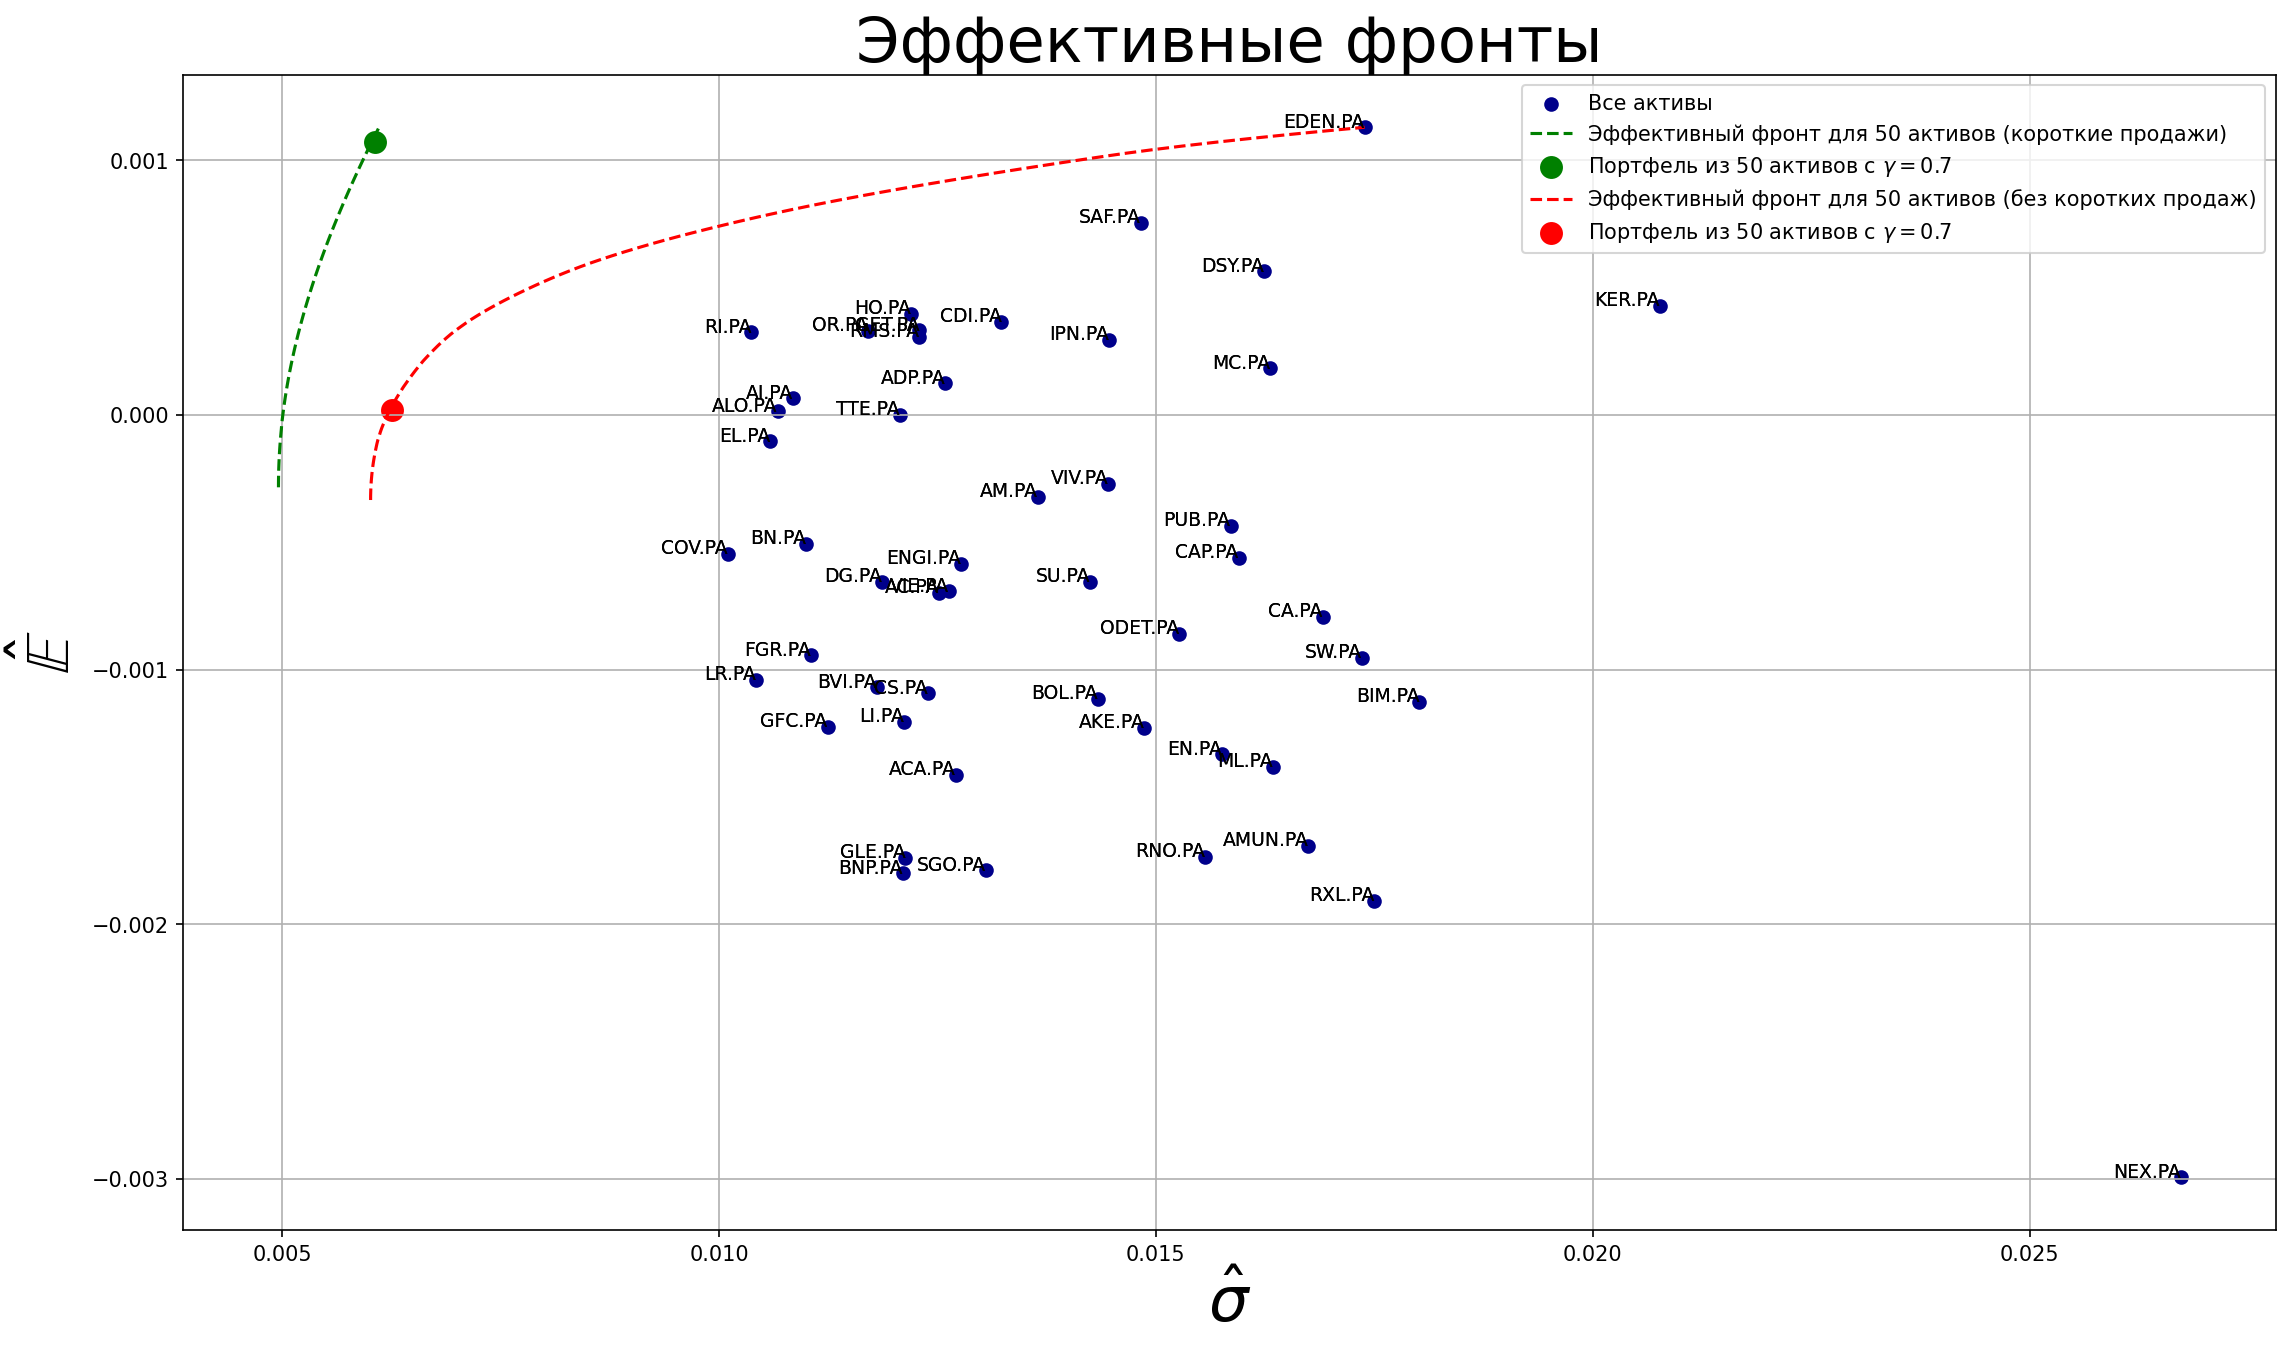

In [26]:
# Определим параметры для эффективных фронтов и портфелей
cov_matrices = [cov_matrix]
mean_returns_list = [log_return_mean]
portfolio_names = [r'Портфель из 50 активов с $\gamma=0.7$']
colors = ['green', 'red']
frontier_colors = ['g--', 'r--']
markers = ['o', 'o']
print_weights = False

# Построение эффективного фронта и оптимального портфеля
plot_efficient_frontier(ms, cov_matrices, mean_returns_list, portfolio_names, colors, frontier_colors, markers, gamma=gamma, print_weights=print_weights)

 ### Оценка VaR и CVaR

In [27]:
df_losses = -df_returns

In [28]:
weights_min_risk_short = optimize_portfolio(cov_matrix, gamma=gamma, mean_returns=log_return_mean, allow_short_sales=True)
weights_min_risk_no_short = optimize_portfolio(cov_matrix, gamma=gamma, mean_returns=log_return_mean, allow_short_sales=False)

In [29]:
short_daily_losses = df_losses @ weights_min_risk_short
no_short_daily_losses = df_losses @ weights_min_risk_no_short

In [30]:
VaR_short = np.percentile(short_daily_losses, 95)
print(f'VaR для портфеля с короткими продажами: {VaR_short}')

VaR_no_short = np.percentile(no_short_daily_losses, 95)
print(f'VaR для портфеля без коротких продаж: {VaR_no_short}')

VaR для портфеля с короткими продажами: 0.009073595289022676
VaR для портфеля без коротких продаж: 0.010149376125432366


In [31]:
CVaR_short = short_daily_losses[short_daily_losses >= VaR_short].mean()
print(f'CVaR для портфеля с короткими продажами: {CVaR_short}')

CVaR_no_short = no_short_daily_losses[no_short_daily_losses >= VaR_no_short].mean()
print(f'CVaR для портфеля без коротких продаж: {CVaR_no_short}')

CVaR для портфеля с короткими продажами: 0.01190392274002494
CVaR для портфеля без коротких продаж: 0.015199902089524197
